# Restaurant Cuisines by Districts

In [1]:

# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json as json


In [2]:
# Load the cuisine data and extract amenity and cuisine tags
gdf_cuisine = gpd.read_file('data/germany-latest-cuisine-merged.osm.pbf', layer='points')
gdf_cuisine= gdf_cuisine.drop(['barrier', 'highway', 'address', 'is_in', 'place', 'man_made', 'ref'], axis=1)

# Build a JSON string to fascilitate the extraction of tags
gdf_cuisine['tags'] = '{' + gdf_cuisine['other_tags'].fillna('').astype(str).str.replace('=>', ':', regex=False) + '}'

# Extract specific tags of interest and drop the original tags columns
gdf_cuisine['cuisine'] = gdf_cuisine.apply(lambda x: json.loads(x['tags'], strict=False).get('cuisine', None), axis=1)
gdf_cuisine['amenity'] = gdf_cuisine.apply(lambda x: json.loads(x['tags'], strict=False).get('amenity', None), axis=1)

# Clean up dataframe by dropping unnecessary columns and filtering for restaurants with names
gdf_cuisine = gdf_cuisine.drop(['other_tags', 'tags'], axis=1)
gdf_cuisine = gdf_cuisine[gdf_cuisine['amenity'] == 'restaurant']
gdf_cuisine = gdf_cuisine[gdf_cuisine['name'].notna()]
gdf_cuisine.head() # 101396 (102932 'amenity'=restaurant,  1536 'name'=NA) of all 210877 rows

,osm_id,name,geometry,cuisine,amenity
1,359832,Hartis Cafe,POINT (6.96393 50.9052),None,restaurant
2,3325823,Grundmühle,POINT (13.65719 51.11308),None,restaurant
5,16257541,Woinemer Hausbrauerei,POINT (8.66979 49.55372),german;regional,restaurant
6,16351361,Galileo,POINT (8.67566 49.55175),pizza,restaurant
7,16351362,Knuspergockel im Eulenspiegel,POINT (8.67488 49.55076),chicken,restaurant


<Axes: >

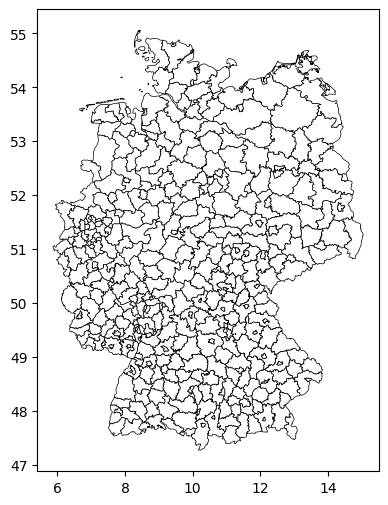

In [3]:
# Load districts data and plot
gdf_krs = gpd.read_file('data/vg5000_12-31.utm32s.shape.ebenen/vg5000_ebenen_1231/VG5000_KRS.shp')
gdf_krs = gdf_krs[['OBJID', 'LKZ', 'AGS', 'GEN', 'geometry']]
gdf_krs = gdf_krs.to_crs(4326)
#gdf_krs.head()
gdf_krs.plot(figsize=(8, 6), color='white', linewidth=0.5, edgecolor='black')

In [4]:
# Merge cuisine data with district data based on spatial location
gdf_cuisine = gpd.sjoin(gdf_cuisine, gdf_krs, how='left', predicate='intersects')
gdf_cuisine.head() # 101396 rows, 402 missing district info (NaN in 'GEN' column) - likely due to restaurants located outside district boundaries or in areas with missing data in the district shapefile

,osm_id,name,geometry,cuisine,amenity,index_right,OBJID,LKZ,AGS,GEN
1,359832,Hartis Cafe,POINT (6.96393 50.9052),None,restaurant,79.0,DEBKGVG500000CJD,NW,05315,Köln
2,3325823,Grundmühle,POINT (13.65719 51.11308),None,restaurant,359.0,DEBKGVG500000CR5,SN,14627,Meißen
5,16257541,Woinemer Hausbrauerei,POINT (8.66979 49.55372),german;regional,restaurant,198.0,DEBKGVG500000CMO,BW,08226,Rhein-Neckar-Kreis
6,16351361,Galileo,POINT (8.67566 49.55175),pizza,restaurant,198.0,DEBKGVG500000CMO,BW,08226,Rhein-Neckar-Kreis
7,16351362,Knuspergockel im Eulenspiegel,POINT (8.67488 49.55076),chicken,restaurant,198.0,DEBKGVG500000CMO,BW,08226,Rhein-Neckar-Kreis


In [5]:
gdf_cuisine['cuisine'] = gdf_cuisine['cuisine'].str.split(';')
gdf_cuisine = gdf_cuisine.explode('cuisine')
gdf_cuisine.head() # 122,000 rows after exploding cuisine types (some restaurants have multiple cuisines, leading to multiple rows per restaurant)


,osm_id,name,geometry,cuisine,amenity,index_right,OBJID,LKZ,AGS,GEN
1,359832,Hartis Cafe,POINT (6.96393 50.9052),None,restaurant,79.0,DEBKGVG500000CJD,NW,05315,Köln
2,3325823,Grundmühle,POINT (13.65719 51.11308),None,restaurant,359.0,DEBKGVG500000CR5,SN,14627,Meißen
5,16257541,Woinemer Hausbrauerei,POINT (8.66979 49.55372),german,restaurant,198.0,DEBKGVG500000CMO,BW,08226,Rhein-Neckar-Kreis
5,16257541,Woinemer Hausbrauerei,POINT (8.66979 49.55372),regional,restaurant,198.0,DEBKGVG500000CMO,BW,08226,Rhein-Neckar-Kreis
6,16351361,Galileo,POINT (8.67566 49.55175),pizza,restaurant,198.0,DEBKGVG500000CMO,BW,08226,Rhein-Neckar-Kreis


In [6]:
krs_cuisine = gdf_cuisine.groupby(['AGS', 'cuisine']).agg({'osm_id': 'count'}).reset_index().rename(columns={'osm_id': 'count'})
krs = gdf_cuisine.groupby('AGS').agg({'osm_id': 'count'}).reset_index().rename(columns={'osm_id': 'total'})

krs_cuisine = krs_cuisine.merge(krs, on='AGS').assign(percentage=lambda x: x['count'] / x['total'] * 100)

krs_cuisine.head()

,AGS,cuisine,count,total,percentage
0,01001,asian,8,106,7.547170
1,01001,balkan,2,106,1.886792
2,01001,barbecue,1,106,0.943396
3,01001,burger,3,106,2.830189
4,01001,chinese,5,106,4.716981


In [7]:
# Add white color for missing values in the cuisine column
# https://github.com/scverse/spatialdata-plot/issues/242

extracted_cmap = plt.get_cmap("YlOrRd", 256)
# using 0.8 instead of 1.0 truncates the colormap
extracted_colors = extracted_cmap(np.linspace(0, 0.8, 256))
# set the color of zero to be transparent
extracted_colors[0, :] = [1.0, 1.0, 1.0, 0.0]

YlOrRd_White_Zero = LinearSegmentedColormap.from_list("YlOrRd_White_Zero", extracted_colors)

<Axes: >

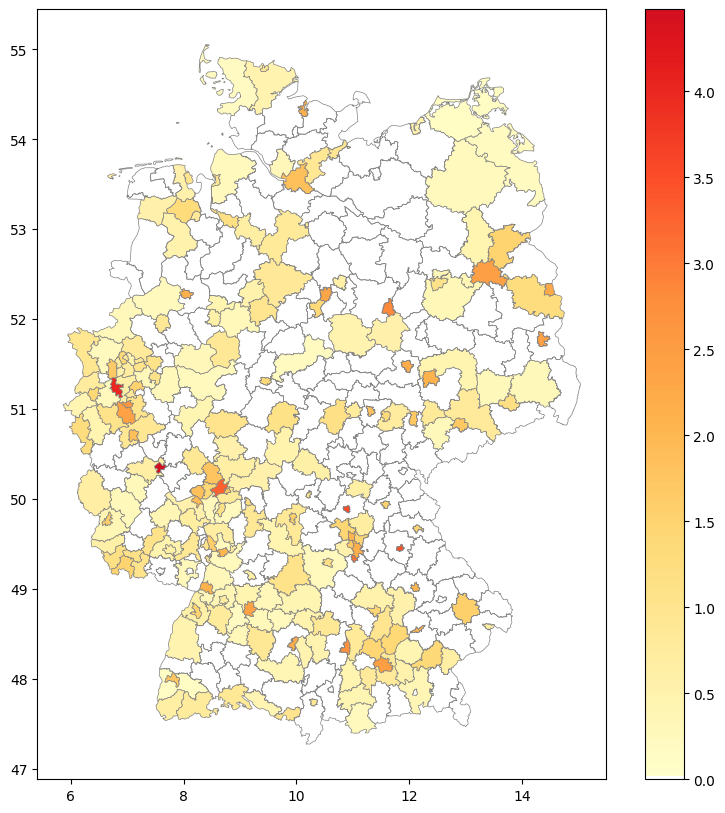

In [8]:
my_cuisine = krs_cuisine[krs_cuisine['cuisine'] == 'japanese']
#my_cuisine = my_cuisine.merge(gdf_krs[['AGS', 'GEN', 'geometry']], on='AGS')
my_krs = gdf_krs.merge(my_cuisine[['AGS', 'percentage']], on='AGS', how='left').fillna(0)
#my_krs.head()
my_krs.plot(column='percentage', cmap=YlOrRd_White_Zero, figsize=(10,10), linewidth=0.5, edgecolor='gray', legend=True)
#my_cuisine.head()


In [9]:
krs_cuisine.head()

,AGS,cuisine,count,total,percentage
0,01001,asian,8,106,7.547170
1,01001,balkan,2,106,1.886792
2,01001,barbecue,1,106,0.943396
3,01001,burger,3,106,2.830189
4,01001,chinese,5,106,4.716981


In [10]:
# Number of Cuisines
cuisine_counts = gdf_cuisine['cuisine'].value_counts().reset_index()
cuisine_counts.columns = ['cuisine', 'count']
cuisine_counts = cuisine_counts[cuisine_counts['cuisine'].notna()]
cuisine_counts = cuisine_counts.sort_values(by='count', ascending=False)
print(cuisine_counts.head(20))

          cuisine  count
0        regional  13387
1         italian  12292
2          german  11425
3           pizza   6828
4           greek   5076
5           asian   3165
6          indian   2169
7         chinese   2098
8          burger   1972
9      vietnamese   1821
10          sushi   1697
11  international   1505
12        turkish   1400
13          kebab   1031
14       bavarian    990
15       japanese    981
16           thai    978
17    steak_house    895
18          pasta    724
19           fish    707
